In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import random_split
import os
import time
import copy

In [2]:
# Set data directory
data_dir = '/Users/niezhiqi/Desktop/课程/深度学习/hw1/EX1/flower_dataset'

# Data augmentation and normalization for training and validation
data_transforms = transforms.Compose([
        # GRADED FUNCTION: Add five data augmentation methods, Normalizating and Tranform to tensor
        ### START SOLUTION HERE ###
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomGrayscale(p=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ### END SOLUTION HERE ###
])

# Load the entire dataset
full_dataset = datasets.ImageFolder(data_dir, data_transforms)

# Automatically split into 80% train and 20% validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Use DataLoader for both train and validation datasets
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

dataloaders = {'train': train_loader, 'val': val_loader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

# Get class names from the dataset
class_names = full_dataset.classes

In [ ]:
# Load pre-trained model and modify the last layer
model = models.resnet18(pretrained=True)

# GRADED FUNCTION: Modify the last fully connected layer of model
### START SOLUTION HERE ###
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 5 classes for flowers
### END SOLUTION HERE ###

# GRADED FUNCTION: Define the loss function
### START SOLUTION HERE ###
criterion = nn.CrossEntropyLoss() 
### END SOLUTION HERE ###

# GRADED FUNCTION: Define the optimizer
### START SOLUTION HERE ###

#优化器为Adam

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

#为优化器定义学习率调度器
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #苹果电脑gpu
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Print learning rate for current epoch
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {current_lr:.6f}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        # GRADED FUNCTION: Backward pass and optimization
                        ### START SOLUTION HERE ###
                        loss.backward()
                        optimizer.step()
                        ### END SOLUTION HERE ###

                running_loss += loss.item() * inputs.size(0)#running loss指的是每个batch的
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()  # Update learning rate based on scheduler

            epoch_loss = running_loss / dataset_sizes[phase]
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase] 

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the model if validation accuracy is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model
                save_dir = 'Ex2/work_dir'
                os.makedirs(save_dir, exist_ok=True)

                # GRADED FUNCTION: Save the best model and its loss and accuracy

                ### START SOLUTION HERE ###
                torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model



In [11]:
import matplotlib.pyplot as plt
import os
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

# Load pre-trained model and modify the last layer
model = models.resnet18(pretrained=True)

# GRADED FUNCTION: Modify the last fully connected layer of model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 5 classes for flowers

# GRADED FUNCTION: Define the loss function
criterion = nn.CrossEntropyLoss()

# GRADED FUNCTION: Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # Initialize lists to store training/validation statistics
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    lr_history = []

    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Print and store learning rate for current epoch
        current_lr = optimizer.param_groups[0]['lr']
        lr_history.append(current_lr)
        print(f'Learning Rate: {current_lr:.6f}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            # Store statistics
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.cpu().numpy())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Save the model if validation accuracy is the best so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                save_dir = 'Ex2/work_dir'
                os.makedirs(save_dir, exist_ok=True)
                torch.save(model.state_dict(), os.path.join(save_dir, 'best_model.pth'))
                
                # Also save the training statistics
                torch.save({
                    'train_loss_history': train_loss_history,
                    'train_acc_history': train_acc_history,
                    'val_loss_history': val_loss_history,
                    'val_acc_history': val_acc_history,
                    'lr_history': lr_history
                }, os.path.join(save_dir, 'training_stats.pth'))

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    # Plot training/validation statistics
    plt.figure(figsize=(15, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label='Train Loss')
    plt.plot(val_loss_history, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label='Train Accuracy')
    plt.plot(val_acc_history, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Save plots
    plt.savefig(os.path.join(save_dir, 'training_curves.png'))
    plt.show()
    
    # Plot learning rate schedule
    plt.figure()
    plt.plot(lr_history)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.savefig(os.path.join(save_dir, 'learning_rate.png'))
    plt.show()

    return model


/Users/niezhiqi/miniconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/niezhiqi/miniconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/29
----------
Learning Rate: 0.001000
train Loss: 0.9985 Acc: 0.6277
val Loss: 1.0160 Acc: 0.6632

Epoch 1/29
----------
Learning Rate: 0.001000
train Loss: 0.7802 Acc: 0.7151
val Loss: 0.7829 Acc: 0.7211

Epoch 2/29
----------
Learning Rate: 0.001000
train Loss: 0.6769 Acc: 0.7467
val Loss: 0.6291 Acc: 0.7719

Epoch 3/29
----------
Learning Rate: 0.001000
train Loss: 0.6346 Acc: 0.7730
val Loss: 0.6719 Acc: 0.7526

Epoch 4/29
----------
Learning Rate: 0.001000
train Loss: 0.6255 Acc: 0.7669
val Loss: 0.5582 Acc: 0.8000

Epoch 5/29
----------
Learning Rate: 0.001000
train Loss: 0.5766 Acc: 0.7950
val Loss: 0.5999 Acc: 0.7842

Epoch 6/29
----------
Learning Rate: 0.001000
train Loss: 0.5922 Acc: 0.7827
val Loss: 0.6516 Acc: 0.7789

Epoch 7/29
----------
Learning Rate: 0.001000
train Loss: 0.5538 Acc: 0.8011
val Loss: 0.6402 Acc: 0.7667

Epoch 8/29
----------
Learning Rate: 0.001000
train Loss: 0.5330 Acc: 0.8112
val Loss: 0.5526 Acc: 0.7947

Epoch 9/29
----------
Learning Rate: 

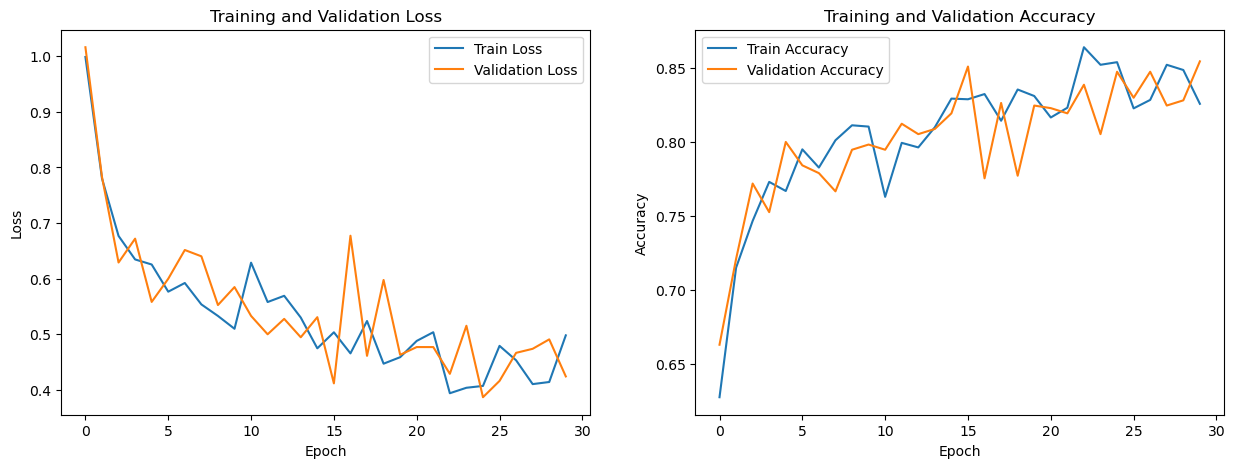

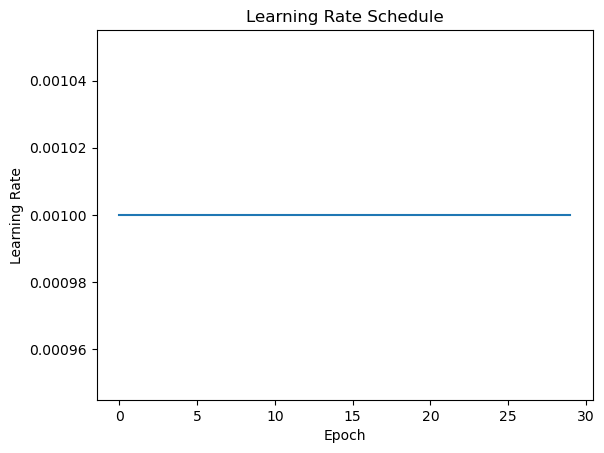

In [12]:
# Train the model
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
model = train_model(model, criterion, optimizer, scheduler, num_epochs=30)


In [ ]:
# Load pre-trained model and modify the last layer
model = models.resnet18(pretrained=True)

# GRADED FUNCTION: Modify the last fully connected layer of model
### START SOLUTION HERE ###
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # 5 classes for flowers
### END SOLUTION HERE ###

# GRADED FUNCTION: Define the loss function
### START SOLUTION HERE ###
criterion = nn.CrossEntropyLoss() 
### END SOLUTION HERE ###

# GRADED FUNCTION: Define the optimizer
### START SOLUTION HERE ###

#优化器为Adam
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

#为优化器定义学习率调度器
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 创建列表来存储训练过程中的指标
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #苹果电脑gpu
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Print learning rate for current epoch
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Learning Rate: {current_lr:.6f}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        # GRADED FUNCTION: Backward pass and optimization
                        ### START SOLUTION HERE ###
                        loss.backward()
                        optimizer.step()
                        ### END SOLUTION HERE ###

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()  # Update learning rate based on scheduler

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase] 

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # 保存当前epoch的指标
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())  # 将tensor转换为Python数值
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc.item())  # 将tensor转换为Python数值
                
        # 检查是否是最佳模型
        if val_acc_history[-1] > best_acc:  # 使用保存的验证准确率
            best_acc = val_acc_history[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
            
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    
    # 保存指标到文件
    save_metrics(train_acc_history, val_acc_history, train_loss_history, val_loss_history)
    
    return model

def save_metrics(train_acc, val_acc, train_loss, val_loss):
    """保存训练和验证的准确率和损失值到CSV文件"""
    import csv
    
    filename = 'training_metrics.csv'
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        # 写入表头
        writer.writerow(['Epoch', 'Train Accuracy', 'Val Accuracy', 'Train Loss', 'Val Loss'])
        # 写入每一行数据
        for i in range(len(train_acc)):
            writer.writerow([i+1, train_acc[i], val_acc[i], train_loss[i], val_loss[i]])
    
    print(f"Metrics saved to {filename}")


In [ ]:
#生成训练中val loss的图像
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms, models
from torch.utils.data import random_split
import time
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import shutil


# GRADED FUNCTION: Plot training and validation loss
def plot_loss(train_loss, val_loss):
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.savefig('Ex2/work_dir/loss_plot.png')  # Save the plot
    plt.show()
# GRADED FUNCTION: Plot training and validation accuracy
def plot_accuracy(train_acc, val_acc):
    plt.figure(figsize=(10, 5))
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig('Ex2/work_dir/accuracy_plot.png')  # Save the plot
    plt.show()
# GRADED FUNCTION: Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('Ex2/work_dir/confusion_matrix.png')  # Save the plot
    plt.show()
# GRADED FUNCTION: Evaluate the model
def evaluate_model(model, dataloaders, dataset_sizes):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set model to evaluate mode

    running_corrects = 0
    all_preds = []
    all_labels = []

    # Iterate over data
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        running_corrects += torch.sum(preds == labels.data)

    epoch_acc = running_corrects.float() / dataset_sizes['val']
    print(f'Validation Accuracy: {epoch_acc:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm, class_names)
    return epoch_acc.item()
# GRADED FUNCTION: Save the model
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')
# GRADED FUNCTION: Load the model
def load_model(model, load_path):
    model.load_state_dict(torch.load(load_path))
    print(f'Model loaded from {load_path}')
    return model





In [ ]:
#plot_loss(train_loss, val_loss)
plot_loss(train_loss, val_loss)
#plot_accuracy(train_acc, val_acc)
# Save the model